# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports
All the imports are defined here

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training"
    testing_dir = "/content/drive/MyDrive/Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [ ]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                index2 = [i for i in range(len(self.imageFolderDataset)) if i != index]
                img1_tuple = self.imageFolderDataset.imgs[random.choice(index2)]
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), img1_tuple[1]

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset1 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.RandomAffine(degrees=(-10, 10), shear=(-5, 5)),
                                                                      transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

folder_dataset.__len__()

370

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


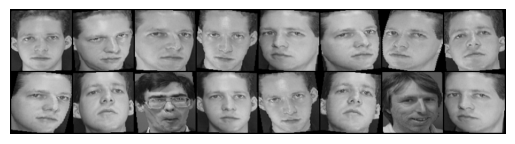

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset1,
                        # shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 250),
            nn.ReLU(inplace=True),
            nn.Linear(250, 15))


    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=100.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(torch.clamp(-20.0 + euclidean_distance, min=0.0), 2)
            + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset1,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.00002 )

counter = []
loss_history = []
iteration_number= 0

In [ ]:
for i, data in enumerate(train_dataloader,0):
    img0, img1 , label, _ = data
    print(label.size().__getitem__(0), end=' ')

64 64 64 64 64 50 

1 1 0


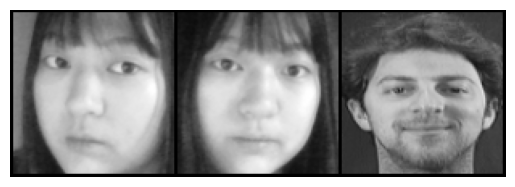

In [ ]:
test_data = dset.ImageFolder("/content/drive/MyDrive/test", transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((100,100)),
    transforms.ToTensor()
    ])
)

test_img0, label0 = test_data[3]
test_img1, label1 = test_data[4]
test_img2, label2 = test_data[0]

# test_img0, label0 = test_data[0]
# test_img1, label1 = test_data[1]
# test_img2, label2 = test_data[4]

print(label0, label1, label2)
test_img0, test_img1, test_img2 = test_img0.unsqueeze(0), test_img1.unsqueeze(0), test_img2.unsqueeze(0)
concatenated = torch.cat((test_img0,test_img1,test_img2),0)
imshow(torchvision.utils.make_grid(concatenated))

test_img0, test_img1, test_img2 = test_img0.cuda(), test_img1.cuda(), test_img2.cuda()


In [ ]:
net.eval()  # 모델을 평가 모드로 변경
# Forward Pass (테스트에서는 모델 파라미터를 업데이트하지 않음)
test_output1, test_output2 = net(test_img0, test_img1)
# _, test_output3 = net(test_img0, test_img2)
test_output3, test_output4 = net(test_img1, test_img2)

test_loss_contrastive = F.pairwise_distance(test_output1, test_output2, keepdim = True)
test_loss_contrastive2 = F.pairwise_distance(test_output3, test_output4, keepdim = True)

net.train()  # 다시 학습 모드로 변경
# 여기서 모델 파라미터는 업데이트되지 않습니다.
print(test_loss_contrastive.item(), test_loss_contrastive2.item())
print(test_output1.tolist())
print(test_output2.tolist())
# print(test_output3.tolist())
print(test_output4.tolist())



34.04801940917969 92.69544219970703
[[-19.90788459777832, -13.43851089477539, 21.729066848754883, -39.166046142578125, 18.17395782470703, -22.69786834716797, 7.285752773284912, 12.704168319702148, -60.382911682128906, -63.02853012084961, 23.9581298828125, -8.571428298950195, 81.01419830322266, 37.95972442626953, -24.095836639404297]]
[[-18.69087028503418, -5.130189418792725, 18.316226959228516, -46.905704498291016, 32.887123107910156, -13.730742454528809, 16.485050201416016, 2.4875450134277344, -75.03351593017578, -66.83540344238281, 25.167736053466797, -21.665061950683594, 77.12528228759766, 40.55649948120117, -34.45970153808594]]
[[-11.15487289428711, -15.908455848693848, -12.319049835205078, -58.529232025146484, 76.4350357055664, 11.897439956665039, 32.38453674316406, -27.312606811523438, -84.20647430419922, -57.66183853149414, 4.202984809875488, -58.85462951660156, 39.028682708740234, 54.85791778564453, -36.70116424560547]]


In [ ]:
counter = []
loss_history = []
loss_history2 = []
loss_history3 = []

0.5#0.8#6.1#3.2#0.4#0.6#>
	Epoch number: 0		Current loss: 1.9194445312023163
>	35.16670227050781		91.53412628173828

1.2#1.6#0.2#1.2#1.2#1.0#>
	Epoch number: 1		Current loss: 1.0632380495468776
>	34.53479766845703		91.90062713623047

2.7#1.8#0.2#3.0#3.1#0.9#>
	Epoch number: 2		Current loss: 1.9729367370406787
>	34.38185119628906		92.46876525878906

6.9#0.0#1.3#0.4#0.1#4.9#>
	Epoch number: 3		Current loss: 2.271199442446232
>	33.931800842285156		94.54169464111328

1.7#1.5#0.9#8.4#1.1#0.2#>
	Epoch number: 4		Current loss: 2.289637014269829
>	33.97528839111328		95.05597686767578

5.3#4.0#0.7#2.9#5.3#0.4#>
	Epoch number: 5		Current loss: 3.0904023200273514
>	33.38334274291992		95.34192657470703

1.3#0.0#0.0#1.1#0.9#8.0#>
	Epoch number: 6		Current loss: 1.8916892465204
>	33.751346588134766		95.15315246582031

11.2#0.9#3.6#1.7#0.1#2.7#>
	Epoch number: 7		Current loss: 3.365280798325936
>	34.26297378540039		95.34400939941406

0.3#0.1#0.2#12.1#1.7#0.0#>
	Epoch number: 8		Current loss: 2.382756

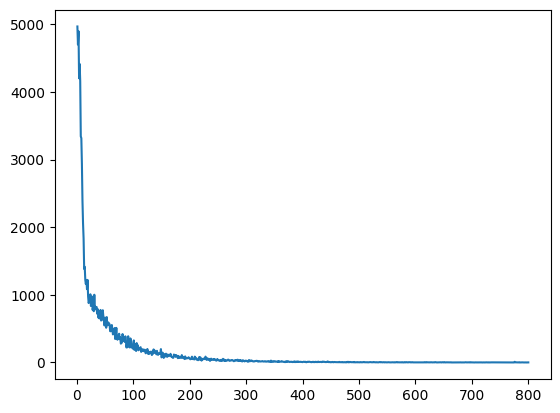

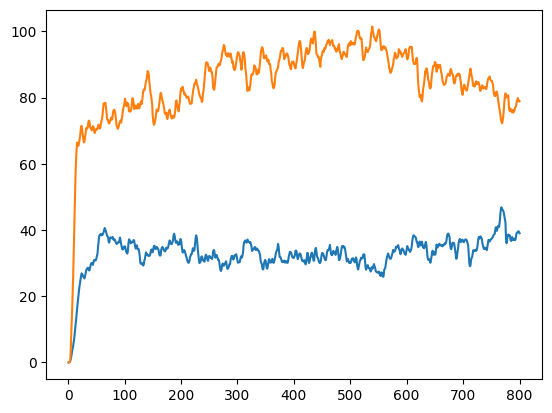

In [ ]:
for epoch in range(0,Config.train_number_epochs * 2):
    val_loss = 0.0
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label, _ = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        print(f'{loss_contrastive.item():.1f}', end='#')
        val_loss += loss_contrastive.item()

    avg_val_loss = val_loss / 6
    print(">\n\tEpoch number: {}\t\tCurrent loss: {}".format(epoch,avg_val_loss))
    iteration_number +=1
    counter.append(iteration_number)
    loss_history.append(avg_val_loss)

    net.eval()  # 모델을 평가 모드로 변경
    # Forward Pass (테스트에서는 모델 파라미터를 업데이트하지 않음)
    test_output1, test_output2 = net(test_img0, test_img1)
    test_output3, test_output4 = net(test_img1, test_img2)
    test_loss_contrastive = F.pairwise_distance(test_output1, test_output2)
    test_loss_contrastive2 = F.pairwise_distance(test_output3, test_output4)

    print(">\t{}\t\t{}\n".format(test_loss_contrastive.item(), test_loss_contrastive2.item()))
    loss_history2.append(test_loss_contrastive.item())
    loss_history3.append(test_loss_contrastive2.item())
    net.train()  # 다시 학습 모드로 변경
    # 여기서 모델 파라미터는 업데이트되지 않습니다.

plt.plot(counter,loss_history)
plt.show()
plt.plot(counter,loss_history2)
plt.plot(counter,loss_history3)
plt.show()

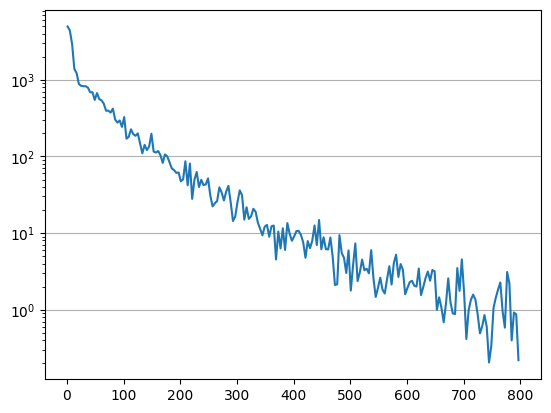

In [ ]:
r1 =0
r2 =1000

loss_history0 = [0.00000001 if element == 0 else element for element in loss_history]
plt.semilogy(counter[r1:r2:4],loss_history0[r1:r2:4])
plt.grid(visible=True, axis='y')
plt.show()

# plt.plot(counter[r1:r2:4],loss_history2[r1:r2:4])
# plt.plot(counter[r1:r2:4],loss_history3[r1:r2:4])
# plt.grid(visible=True, axis='y')
# plt.show()

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

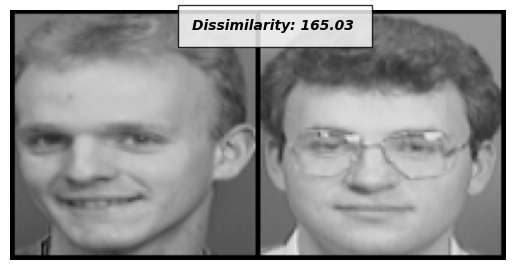

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-19.5095, -27.6609,  -8.5941, -48.2822,  52.0448,   1.3603,  14.9618,
          -9.5502, -66.6055, -44.1443,  -2.8465, -40.2490,  40.1884,  56.0843,
         -21.6321]], device='cuda:0', grad_fn=<AddmmBackward0>)
21033.3515625 0.0


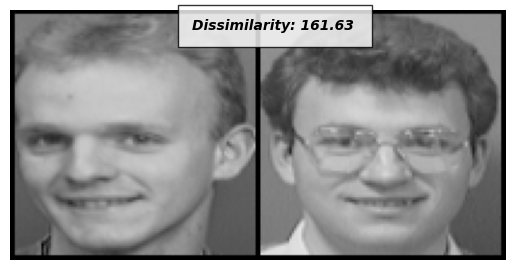

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-20.9024, -35.8599, -14.4726, -61.4561,  70.7636,   4.5417,  22.0226,
         -16.7667, -82.9668, -54.9814,  -4.9101, -53.6172,  44.4923,  69.8168,
         -27.3417]], device='cuda:0', grad_fn=<AddmmBackward0>)
20059.21875 0.0


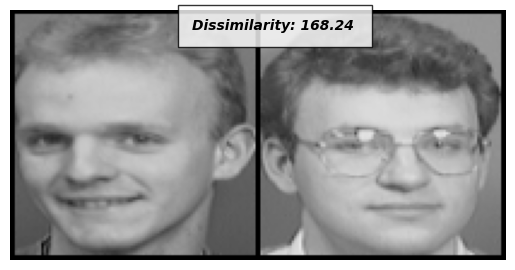

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-20.7419, -29.7887, -13.5216, -56.7198,  64.7696,   6.4448,  20.1450,
         -15.7377, -78.4723, -48.9071,  -4.9091, -51.3720,  40.1988,  63.8725,
         -27.5635]], device='cuda:0', grad_fn=<AddmmBackward0>)
21975.193359375 0.0


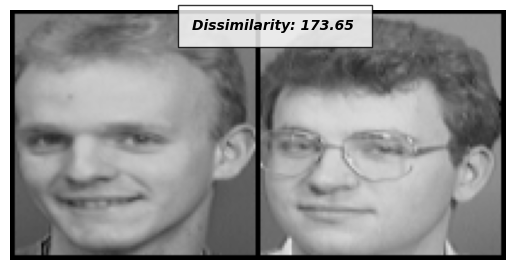

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-24.9236, -20.5538,  -7.4558, -49.2411,  49.4005,   5.0646,  12.9214,
          -8.9669, -71.8288, -37.9463,  -4.9394, -41.9559,  35.6978,  55.8913,
         -27.4148]], device='cuda:0', grad_fn=<AddmmBackward0>)
23609.65234375 0.0


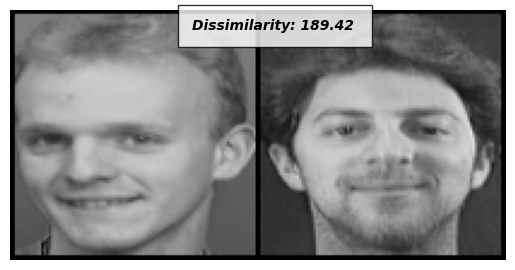

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -9.4950, -17.0901, -11.5660, -59.2513,  76.5922,  11.9367,  34.1353,
         -27.0867, -83.6106, -59.8512,   6.6126, -58.1187,  40.8149,  54.3297,
         -37.1930]], device='cuda:0', grad_fn=<AddmmBackward0>)
28703.1875 0.0


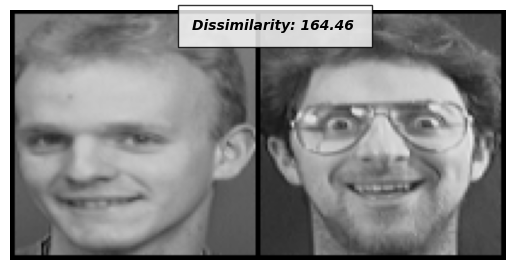

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 11.9191, -44.0227,  -0.4560, -20.4547,  29.8003, -25.4721,  14.4032,
           5.0398, -19.3377, -64.6499,  18.3781, -10.2471,  59.6479,  29.6662,
           4.7946]], device='cuda:0', grad_fn=<AddmmBackward0>)
20867.416015625 0.0


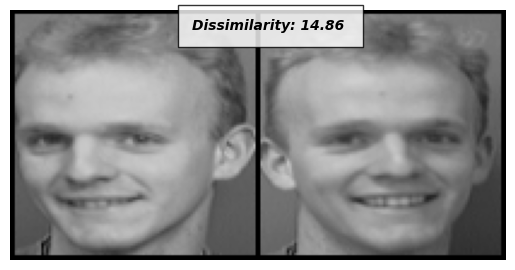

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -38.6916, -106.5908,    1.4043,  -60.2778,   42.1762,  -53.9715,
           -8.7112,   38.3145,  -68.2305,  -97.4049,   -1.8765,  -17.8642,
          124.3818,  104.0783,   12.4052]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0.0 7248.31689453125


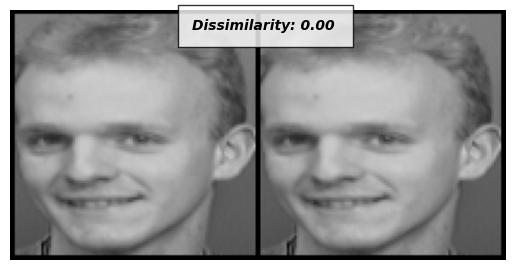

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0.0 9999.998046875


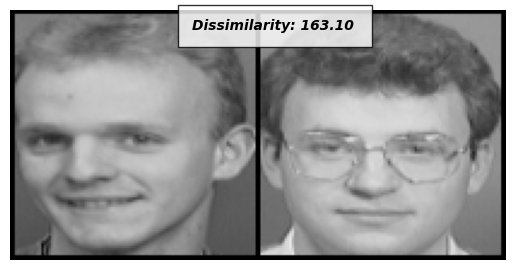

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-20.7482, -27.6156,  -7.8527, -49.2778,  51.8745,   0.7666,  14.6238,
          -8.8460, -68.2527, -44.7685,  -2.7257, -40.1728,  41.3660,  57.1372,
         -22.2704]], device='cuda:0', grad_fn=<AddmmBackward0>)
20478.6953125 0.0


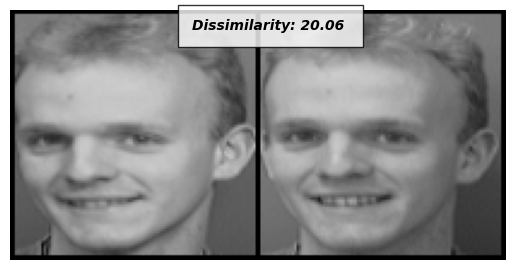

tensor([[ -45.3459, -103.1872,    4.1449,  -64.3390,   42.9650,  -52.8192,
          -10.1656,   38.5086,  -77.3207,  -97.3387,   -2.9320,  -20.6445,
          127.8206,  107.2927,    7.5783]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -39.2388, -100.8604,   -1.5193,  -63.0403,   47.5741,  -47.1304,
           -5.5481,   31.7363,  -73.3380,  -93.3066,   -3.7565,  -24.4875,
          115.7577,  103.8415,    7.7784]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0.0033133693505078554 6390.79296875



In [ ]:
net.eval()

folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset2 = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset2,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_,_ = next(dataiter)
x00 = siamese_dataset2[29][0].unsqueeze(0)


for i in range(10):
    _,x1,label2, label3 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss_contrastive = criterion(output1,output2,0)
    loss_contrastive2 = criterion(output1,output2,1)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} '.format(euclidean_distance.item()))
    print(output1)
    print(output2)
    print(loss_contrastive.item(), loss_contrastive2.item())

net.train()
print()

In [ ]:
# 모델의 가중치를 확인하려면 모델의 state_dict를 얻습니다.
model_state_dict = net.state_dict()

# state_dict를 출력하면 모델의 가중치와 편향 등이 나열됩니다.
print("Model's state_dict:")
for param_tensor in model_state_dict:
    print(param_tensor, "============\n", model_state_dict[param_tensor])


In [ ]:
test_dir = '/content/drive/MyDrive/test2'
test_data2 = dset.ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((100,100)),
    transforms.ToTensor()
    ])
)
test_loader2 = DataLoader(test_data2)


test_list = []
net.eval()
with torch.no_grad():
    for img1, label in test_loader2:
        output2 = net.forward_once(img1.cuda())
        test_list.append([output2, label])
net.train()
classes = test_data2.classes
for idx, i in enumerate(test_list):
    print('\n=====================', idx , '=====================')
    k = 0
    for j in test_list:
        if j[1] == k:
            if k:
                print('')
            print(f'{classes[k]:10s}', end='\t')
            k += 1
        print(int(F.pairwise_distance(i[0], j[0]).item()), end='\t')


===================== 0 =====================
BHM       	0	18	6	5	
BHM2      	3	25	8	4	
SYJ       	135	149	134	156	
===================== 1 =====================
BHM       	18	0	19	20	
BHM2      	20	25	16	17	
SYJ       	146	158	143	166	
===================== 2 =====================
BHM       	6	19	0	9	
BHM2      	6	30	3	4	
SYJ       	137	149	135	157	
===================== 3 =====================
BHM       	5	20	9	0	
BHM2      	3	23	11	8	
SYJ       	132	148	133	154	
===================== 4 =====================
BHM       	3	20	6	3	
BHM2      	0	26	8	5	
SYJ       	134	148	134	155	
===================== 5 =====================
BHM       	25	25	30	23	
BHM2      	26	0	31	28	
SYJ       	136	158	142	161	
===================== 6 =====================
BHM       	8	16	3	11	
BHM2      	8	31	0	4	
SYJ       	139	149	135	158	
===================== 7 =====================
BHM       	4	17	4	8	
BHM2      	5	28	4	0	
SYJ       	138	150	135	158	
===================== 8 =====================
BHM       	13

In [ ]:
torch.save(net.state_dict(), 'model64_250+15_20+100_8000-5.pth')

In [ ]:
net.load_state_dict(torch.load(('/content/model64_250+15_20+100_8000-5.pth')))

<All keys matched successfully>